## Joining Labeled Data

In [4]:
# Load Libraries 
import geopandas as gpd
import pandas as pd


In [35]:
# Load shapefiles
formal_gdf = gpd.read_file("landuse_class/formal.shp")
informal_gdf = gpd.read_file("landuse_class/informal.shp")
vegetation_gdf = gpd.read_file("landuse_class/vegetation.shp")

# Drop 'Id' columns in formal and vegetation
formal_gdf = formal_gdf.drop(columns=["Id"], errors='ignore')
vegetation_gdf = vegetation_gdf.drop(columns=["Id"], errors='ignore')

# Combine all into a single GeoDataFrame
combined_gdf = pd.concat([formal_gdf, informal_gdf, vegetation_gdf], ignore_index=True)

# Check the result (total of 900 points per lu class)
print(combined_gdf.head())
print(combined_gdf["landuse"].value_counts())

  landuse  database                   geometry
0  formal      1984  POINT (36.81875 -1.28296)
1  formal      1984  POINT (36.82147 -1.28555)
2  formal      1984  POINT (36.82169 -1.28429)
3  formal      1984  POINT (36.82322 -1.28458)
4  formal      1984  POINT (36.81933 -1.28491)
landuse
formal        900
informal      900
vegetation    900
Name: count, dtype: int64


In [36]:
# Check Projection
print(combined_gdf.crs)

EPSG:4326


## Load Landsat TIF files
Load the images through public API from Dropbox

In [11]:
import requests
import os 

In [61]:
# Create new output folder 
output_dir = "landsat_images"
os.makedirs(output_dir, exist_ok=True)

# Download multiple files
landsat_files = {
    "1984": "https://www.dropbox.com/scl/fi/nk6xavounp62ua13knj8z/nairobi_landsat_1984_allbands.tif?rlkey=1hy39oiei4fwcsahydg007n6s&st=smighyej&dl=1",
    "2009": "https://www.dropbox.com/scl/fi/flagfp77yvcyxt0b7plyj/nairobi_landsat_2009_allbands.tif?rlkey=etoqn6whwlkkz08cis68oyp6q&st=gpi4nlk5&dl=1",
    "2019": "https://www.dropbox.com/scl/fi/l09necnzqgyigbd13iddp/nairobi_landsat_2019_allbands.tif?rlkey=0gec6urstoqomk6141f2ag5re&st=4h1715d2&dl=1"
}

for year, url in landsat_files.items():
    output_path = os.path.join(output_dir, f"landsat_{year}.tif")
    r = requests.get(url)
    with open(output_path, 'wb') as f:
        f.write(r.content)
    print(f"Downloaded landsat_{year}.tif to {output_path}")


Downloaded landsat_1984.tif to landsat_images/landsat_1984.tif
Downloaded landsat_2009.tif to landsat_images/landsat_2009.tif
Downloaded landsat_2019.tif to landsat_images/landsat_2019.tif


## Preprocessing

In [48]:
# Load Libraries
import rasterio
import rasterio.mask
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from shapely.geometry import mapping
from shapely.geometry import box

In [62]:
# Check Projection
landsat_1984 = "landsat_images/landsat_1984.tif"

# Open the image and print its CRS
with rasterio.open(landsat_1984) as src:
    print("CRS:", src.crs)

CRS: EPSG:4326


### Split Training Data by Year

In [63]:
# Create Geodataframes with the labeled data by year
gdf_1984 = combined_gdf[combined_gdf['database'] == 1984]
gdf_2009 = combined_gdf[combined_gdf['database'] == 2009]
gdf_2019 = combined_gdf[combined_gdf['database'] == 2019]

In [64]:
# Classifier function

def classify_year(year, gdf, tif_path, out_path):
    # Create output directory if it doesn't exist
    os.makedirs(os.path.dirname(out_path), exist_ok=True)

    # Open raster
    with rasterio.open(tif_path) as src:
        image = src.read()  # (bands, rows, cols)
        transform = src.transform
        raster_crs = src.crs
        raster_bounds = src.bounds
        meta = src.meta.copy()
        _, n_rows, n_cols = image.shape

    # Reproject training points to match raster
    if gdf.crs != raster_crs:
        gdf = gdf.to_crs(raster_crs)

    # Filter training points to those within raster extent
    raster_geom = box(*raster_bounds)
    gdf = gdf[gdf.geometry.within(raster_geom)]
    print(f"[{year}] Points after spatial filter: {len(gdf)}")

    if len(gdf) == 0:
        raise ValueError(f"No valid training points within raster bounds for year {year}.")

    # Extract coordinates and labels
    coords = [(geom.x, geom.y) for geom in gdf.geometry]
    labels = gdf['landuse'].astype('category').cat.codes.values

    # Convert coordinates to row/col pixel positions
    rows_cols = [~transform * (x, y) for x, y in coords]
    rows, cols = zip(*rows_cols)
    rows = np.array(rows)
    cols = np.array(cols)

    # Filter NaNs
    valid = (~np.isnan(rows)) & (~np.isnan(cols))
    rows = rows[valid].astype(int)
    cols = cols[valid].astype(int)
    labels = labels[valid]

    # Filter to points within raster dimensions
    in_bounds = (rows >= 0) & (rows < n_rows) & (cols >= 0) & (cols < n_cols)
    rows = rows[in_bounds]
    cols = cols[in_bounds]
    labels = labels[in_bounds]

    print(f"[{year}] Training samples used: {len(labels)}")

    # Extract pixel values for training
    samples = image[:, rows, cols].T  # shape: (samples, bands)

    # Train Random Forest model
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(samples, labels)

    # Classify entire raster
    reshaped_img = image.reshape(image.shape[0], -1).T
    predictions = clf.predict(reshaped_img)
    classified = predictions.reshape((n_rows, n_cols))

    # Save output raster
    meta.update({"count": 1, "dtype": 'int16'})
    with rasterio.open(out_path, "w", **meta) as dest:
        dest.write(classified.astype('int16'), 1)

    print(f"[{year}] Classification complete. Saved to {out_path}")



In [65]:
# Create output directory if not exists
os.makedirs("classified_outputs", exist_ok=True)

# Run Classifier 
classify_year(
    year='1984',
    gdf=gdf_1984,
    tif_path='landsat_images/landsat_1984.tif',
    out_path='classified_outputs/classified_1984.tif'
)

classify_year(
    year='2009',
    gdf=gdf_2009,
    tif_path='landsat_images/landsat_2009.tif',
    out_path='classified_outputs/classified_2009.tif'
)

classify_year(
    year='2019',
    gdf=gdf_2019,
    tif_path='landsat_images/landsat_2019.tif',
    out_path='classified_outputs/classified_2019.tif'
)


[1984] Points after spatial filter: 899
[1984] Training samples used: 899
[1984] Classification complete. Saved to classified_outputs/classified_1984.tif
[2009] Points after spatial filter: 900
[2009] Training samples used: 900
[2009] Classification complete. Saved to classified_outputs/classified_2009.tif
[2019] Points after spatial filter: 900
[2019] Training samples used: 880
[2019] Classification complete. Saved to classified_outputs/classified_2019.tif


## Urban Sprawl Analysis
### Quantify Area Change by Land Use Class

In [66]:
# Function calculating area of each land use class (by converting number of pixels)

def calculate_area_by_class(classified_tif, pixel_size=30, year=None):
    with rasterio.open(classified_tif) as src:
        classified = src.read(1)
        transform = src.transform

    classes, counts = np.unique(classified, return_counts=True)

    area_sqkm = counts * (pixel_size**2) / 1e6  # convert m² to km²
    result = pd.DataFrame({
        'class_code': classes,
        'area_km2': area_sqkm
    })

    if year:
        result['year'] = year

    return result

# Run for each year
df_1984 = calculate_area_by_class('classified_outputs/classified_1984.tif', year=1984)
df_2009 = calculate_area_by_class('classified_outputs/classified_2009.tif', year=2009)
df_2019 = calculate_area_by_class('classified_outputs/classified_2019.tif', year=2019)

# Combine
area_summary = pd.concat([df_1984, df_2009, df_2019], ignore_index=True)
# Add in Class Names
class_names = {0: "Formal", 1: "Informal", 2: "Vegetation"}
area_summary['landuse'] = area_summary['class_code'].map(class_names)

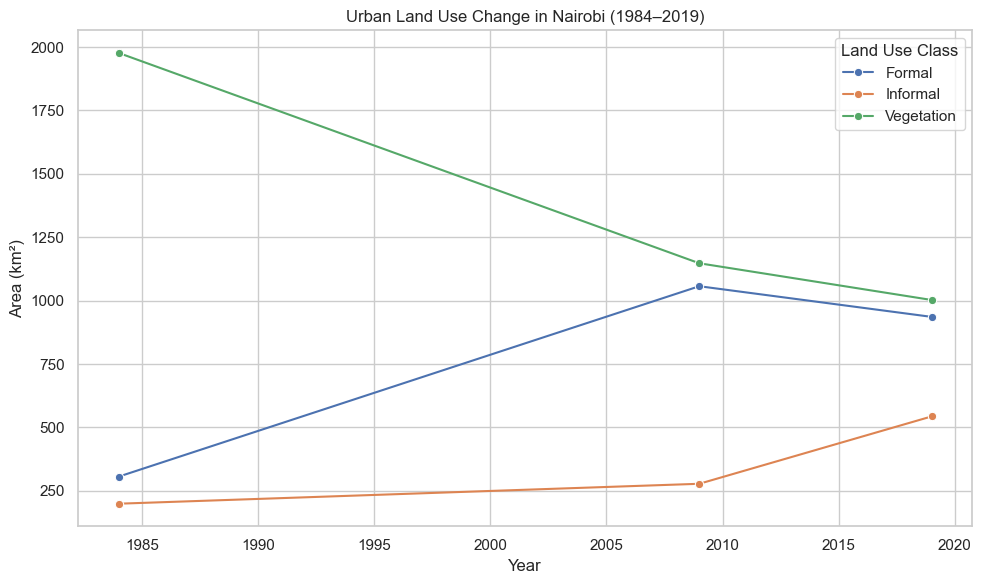

In [67]:
# Map Urban Sprawl Trends
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style='whitegrid')
plt.figure(figsize=(10, 6))
sns.lineplot(data=area_summary, x='year', y='area_km2', hue='landuse', marker='o')
plt.title('Urban Land Use Change in Nairobi (1984–2019)')
plt.ylabel('Area (km²)')
plt.xlabel('Year')
plt.legend(title='Land Use Class')
plt.tight_layout()
plt.show()


In [68]:
# Comparing Informal and Formal Growth
pivoted = area_summary.pivot(index='year', columns='landuse', values='area_km2').reset_index()

pivoted['informal_growth'] = pivoted['Informal'].pct_change() * 100
pivoted['formal_growth'] = pivoted['Formal'].pct_change() * 100

print(pivoted[['year', 'Informal', 'Formal', 'informal_growth', 'formal_growth']])


landuse  year  Informal     Formal  informal_growth  formal_growth
0        1984  199.1349   305.6985              NaN            NaN
1        2009  277.7193  1056.7998        39.462897     245.700028
2        2019  543.3030   935.9712        95.630264     -11.433443


## Predict Land Use
Given that we only trained classifers for three years with labeled data, now, we want to apply those models to predict land use for the remaning years with unlabeled data:
- Landsat 5 Model (1984): 1994
- Landsat 7 model (2009): 1999, 2004
- Landsat 8 OLI model (2019): 2014, 2023

Access Links to Landsat Images:
- 1994: https://www.dropbox.com/scl/fi/yprh8z2e4en0rrbb68so0/nairobi_landsat_1994_fallback_allbands.tif?rlkey=u8up26q0w0kwyecajlzekhisr&st=a4xgaxnh&dl=1
- 1999: https://www.dropbox.com/scl/fi/twnukoz1nkj9x3mpcpea2/nairobi_landsat_1999_fallback_allbands.tif?rlkey=154s8whnxmcjf9og2awwc043x&st=mdi0jf7l&dl=1
- 2004: https://www.dropbox.com/scl/fi/pz3o5syavhb6e9nzsvzyk/nairobi_landsat_2004_allbands.tif?rlkey=j23q1xfr5nlxf15z4s7c7oilo&st=76j9ie3y&dl=1 
- 2014: https://www.dropbox.com/scl/fi/p1j3y9p05akytyzf8cfqs/nairobi_landsat_2014_allbands.tif?rlkey=w5xz2na5iw2k8qs8tpi956jlx&st=ffnh9ura&dl=1 
- 2023: https://www.dropbox.com/scl/fi/a51vdlt7017ho1trgxpzg/nairobi_landsat_2023_allbands.tif?rlkey=z6jg7oh4dwtciwlae0qzlrajk&st=ed651nug&dl=1 


In [ ]:
# Apply classifier 